In [127]:
import pandas as pd
import datetime as dt
from functools import wraps
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz 


In [37]:
df.head()

,det,woord,woord_vec,2d_tsnse_x,2d_tsnse_y,3d_tsnse_x,3d_tsnse_y,3d_tsnse_z
0,de,gemeente,"[1.0568, -0.94515, 0.99421, -0.68407, 2.9815, ...",17.886803,-109.494179,8.696596,4.315295,-8.182873
1,de,provincie,"[1.716, -1.4213, -0.50323, -2.4624, 1.5628, 0....",85.504738,-53.128902,-0.691837,12.283213,-2.905879
2,het,dorp,"[1.9532, 0.047137, -0.70945, -2.8567, -0.33987...",82.390869,-41.150593,-5.146375,10.039696,-4.603694
4,de,eeuw,"[5.555, -2.933, -2.232, -2.0864, 1.9924, 0.687...",-55.283062,-59.481743,1.511579,-3.374212,-0.988650
7,het,moment,"[1.7155, 1.0782, 1.4089, -2.5729, 0.50998, -1....",-46.525166,-65.703644,2.505650,-2.254646,2.607251


In [38]:
# Make sure that there are not repeated words
assert len(set(df.woord)) == df.shape[0]

Build feature based on hand crafted features

### Base line features
* How many characters does it have ?
* Is there dash in the word?
* Does it end with 'en' or 'jes' then it is plural

### Additional features
* Is the word singular or plural?
* Is it a place, organization  or person ? 
* Is the word made of more than one word ?

In [123]:

def log_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = func(*args, **kwargs)
        time_taken = str(dt.datetime.now() - tic)
        print(f"just ran step {func.__name__} shape={result.shape} took {time_taken}s")
        return result
    return wrapper



@log_step
def start_pipeline(dataf):
    return dataf.copy() 

@log_step
def select_rows_by_column_values(dataf,column,values):
    return (dataf[dataf[column].isin(values)])

@log_step
def select_columns(dataf, columns):
    return (dataf[columns])

@log_step
def count_characters(dataf,column_name='woord'):
    dataf['character_count'] = dataf[column_name].apply(lambda x : len(x))
    return dataf

@log_step
def has_dash(dataf,column_name='woord'):
    dataf['has_dash'] = dataf[column_name].apply(lambda x :'-' in x)
    return dataf
    

@log_step
def ends_with_en(dataf,column_name='woord'):
    dataf['ends_with_en'] = dataf[column_name].apply(lambda x :'en' in x[-2:])
    return dataf

@log_step
def ends_with_jes(dataf,column_name='woord'):
    dataf['ends_with_jes'] = dataf[column_name].apply(lambda x :'jes' in x[-3:])
    return dataf



def generate_baseline_features(df):
    return (
            df.pipe(select_columns,columns=['woord','det']).\
                pipe(start_pipeline).\
                pipe(select_rows_by_column_values,column='det',values=['de','het']).\
                pipe(count_characters).\
                pipe(has_dash).\
                pipe(ends_with_en).\
                pipe(ends_with_jes)
        )

In [124]:
df_baseline=generate_baseline_features(df)

just ran step select_columns shape=(23302, 2) took 0:00:00.002730s
just ran step start_pipeline shape=(23302, 2) took 0:00:00.001177s
just ran step select_rows_by_column_values shape=(23276, 2) took 0:00:00.006444s
just ran step count_characters shape=(23276, 3) took 0:00:00.016898s
just ran step has_dash shape=(23276, 4) took 0:00:00.008712s
just ran step ends_with_en shape=(23276, 5) took 0:00:00.008686s
just ran step ends_with_jes shape=(23276, 6) took 0:00:00.007210s


In [160]:
df_baseline.det.value_counts()

de     17579
het     5697
Name: det, dtype: int64

In [167]:
17579-5697

11882

The data is highly skewed. Upsample the minority class

In [179]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_baseline[df_baseline.det=='de']
df_minority = df_baseline[df_baseline.det=='het']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=17579,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.det.value_counts()

het    17579
de     17579
Name: det, dtype: int64

In [180]:
df_upsampled.head()

,woord,det,character_count,has_dash,ends_with_en,ends_with_jes
0,gemeente,de,8,False,False,False
1,provincie,de,9,False,False,False
4,eeuw,de,4,False,False,False
10,dorpen,de,6,False,True,False
11,naam,de,4,False,False,False


## Train a simple decision tree

In [181]:
# Extract the name of features. This can be done by removing the column 'woord' and 'det'
feature_names = list(set(df_upsampled.columns.to_list()) - set(['woord','det']))
X = df_upsampled.pipe(select_columns,columns=feature_names)
y = df_upsampled['det']

just ran step select_columns shape=(35158, 4) took 0:00:00.002778s


In [214]:
clf = DecisionTreeClassifier(random_state=0,max_depth=2,max_features='auto',max_leaf_nodes=2)

In [215]:
cross_val_score(clf, X, y, cv=20)

array([0.50568828, 0.5       , 0.50170648, 0.50341297, 0.50227531,
       0.50227531, 0.50511945, 0.50056883, 0.50227531, 0.50568828,
       0.50511945, 0.50341297, 0.50170648, 0.50511945, 0.50341297,
       0.50511945, 0.50455063, 0.50796359, 0.5071144 , 0.50540694])

In [216]:
clf = clf.fit(X, y)

In [217]:
 dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=feature_names,  
    class_names=y.unique().tolist(),
    filled=True, rounded=True,  
    special_characters=True)  

In [218]:
graph = graphviz.Source(dot_data)  

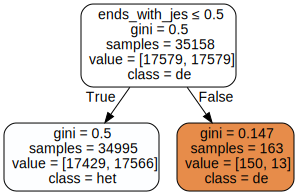

In [219]:
graph